# Time lagged-autoencoder using Recurrent Neural Networks

### In order to install TF 2,0 on google colab uncomment and run below code line 

In [86]:
# !pip install -q tensorflow==2.0.0-alpha0

# Imports

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RepeatVector, TimeDistributed, SimpleRNN, Dropout, LeakyReLU
from tensorflow import keras
import tensorflow as tf
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from itertools import permutations
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D


# Prepare data

## Get data from provided file

In [88]:
def get_data():
    with np.load('dimredux-challenge-01-data.npz') as fh:
        data_x = fh['data_x']
        validation_x = fh['validation_x']
        validation_y = fh['validation_y']


    return data_x, validation_x, validation_y

## Generate train and validation data

In [89]:
data_x, validation_x, validation_y = get_data()

data_x = data_x.astype('float32')

original_data_x = np.copy(data_x)
TAU = 8

data_x = original_data_x[:-TAU]
shifted_data_x = original_data_x[TAU:]


In [90]:
print(f"original_data_x shape: {original_data_x.shape}")
print(f"data_x shape: {data_x.shape}")
print(f"shifted_data_x shape: {shifted_data_x.shape}")
print(f"validation_x shape: {validation_x.shape}")
print(f"validation_y shape: {validation_y.shape}")

original_data_x shape: (100000, 3)
data_x shape: (99992, 3)
shifted_data_x shape: (99992, 3)
validation_x shape: (1000, 3)
validation_y shape: (1000,)


# Visualize original data

## Visualize training data

### Visualization 3D

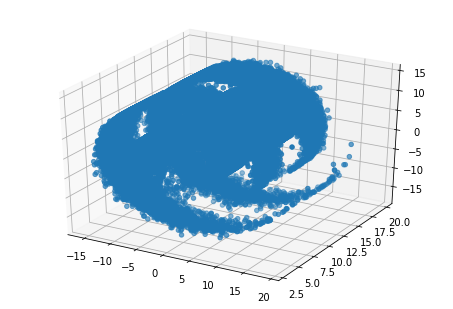

In [91]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(data_x[:, 0], data_x[:, 1], data_x[:, 2])
pyplot.show()

### Vizualize 2D

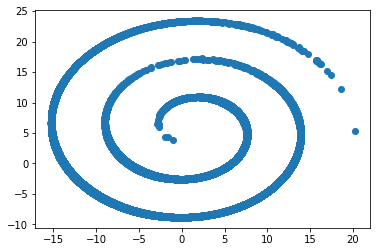

In [92]:
pca = PCA(n_components=2)
principal_components_original_x = pca.fit_transform(original_data_x)

plt.scatter(principal_components_original_x[:, 0], principal_components_original_x[:, 1])
plt.show()

## Visualize validation data

### Visualization 3D

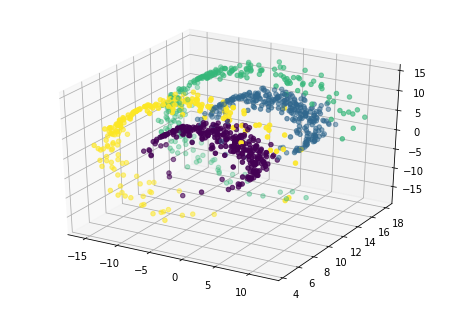

In [93]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(validation_x[:, 0], validation_x[:, 1], validation_x[:, 2], c=validation_y)
pyplot.show()

### Visualization 2D

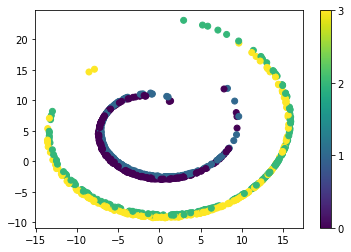

In [94]:
pca = PCA(n_components=2)
principal_components_validation_x = pca.fit_transform(validation_x)

plt.scatter(principal_components_validation_x[:, 0], principal_components_validation_x[:, 1], c=validation_y)
plt.colorbar(ticks=np.linspace(0,3,4))
plt.show()

## Make data zero-mean

In [95]:
data_x = data_x - np.mean(data_x, axis=0)
shifted_data_x =  shifted_data_x - np.mean(shifted_data_x, axis=0)
original_data_x = original_data_x -  np.mean(original_data_x, axis=0)
validation_x = validation_x - np.mean(validation_x, axis=0)

## Whitten data

In [96]:
pca_whiten = PCA(whiten=True)

data_x = pca_whiten.fit_transform(data_x)
shifted_data_x = pca_whiten.fit_transform(shifted_data_x)
original_data_x = pca_whiten.fit_transform(original_data_x)
validation_x = pca_whiten.fit_transform(validation_x)

# Visualize data after transformations

## Visualize training data

### Visualization 3D

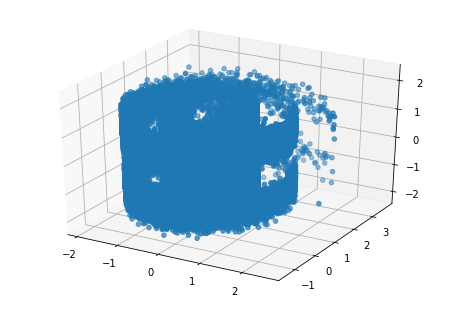

In [97]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(data_x[:, 0], data_x[:, 1], data_x[:, 2])
pyplot.show()

### Visualization 2D

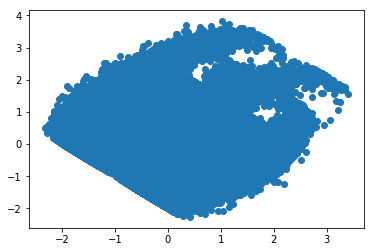

In [98]:
pca = PCA(n_components=2)
principal_components_data_x = pca.fit_transform(data_x)

plt.scatter(principal_components_data_x[:, 0], principal_components_data_x[:, 1])
plt.show()

## Visualize validation data

### Visualization 3D

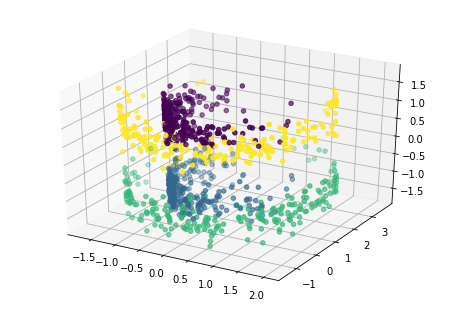

In [99]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(validation_x[:, 0], validation_x[:, 1], validation_x[:, 2], c=validation_y)
pyplot.show()

### Visualization 2D

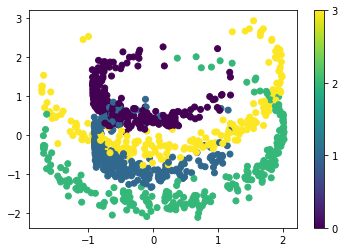

In [100]:
pca = PCA(n_components=2)
principal_components_validation_x = pca.fit_transform(validation_x)

plt.scatter(principal_components_validation_x[:, 0], principal_components_validation_x[:, 1], c=validation_y)
plt.colorbar(ticks=np.linspace(0,3,4))
plt.show()

## Expand dims in order to use it with RNNs

In [101]:
data_x = np.expand_dims(data_x, axis=2)
shifted_data_x = np.expand_dims(shifted_data_x, axis=2)
data_x_copy = np.expand_dims(data_x_copy, axis=2)
validation_x = np.expand_dims(validation_x, axis=2)

## Dataset API 

In [102]:
dataset = tf.data.Dataset.from_tensor_slices((data_x, shifted_data_x)).batch(BATCH_SIZE)

# Prepare model

In [103]:
def get_model():
    encoder_input = keras.Input(shape=(3, 1), name='input')
    x = SimpleRNN(200, return_sequences = True)(encoder_input)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    x = SimpleRNN(100,return_sequences = True)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)


    x = SimpleRNN(1, name="hidden_state", return_sequences = False)(x)
    hidden_state = LeakyReLU()(x)


    encoder = keras.Model(encoder_input, hidden_state, name="encoder")

    x = RepeatVector(3)(hidden_state)

    x = SimpleRNN(100, return_sequences=True)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    x = SimpleRNN(200, return_sequences=True)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    decoder_output = TimeDistributed(Dense(1))(x)

    auto_encoder = keras.Model(encoder_input, decoder_output, name="auto_encoder")

    return auto_encoder, encoder

## Model summary

In [104]:
model, encoder = get_model()

model.summary()

print()

encoder.summary()

Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3, 1)]            0         
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 3, 200)            40400     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 3, 200)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 3, 200)            0         
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 3, 100)            30100     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 3, 100)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 3, 100)           

# Set training parameters

In [105]:
EPOCHS = 80
BATCH_SIZE = 512
BUFFER_SIZE = 128
LEARNING_RATE = 1e-4

# Training 

## Define loss function and optimizer

In [106]:
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
loss = tf.keras.losses.MeanSquaredError()

## Define training function

In [107]:
def train(model, dataset):
    """
    Function optimizes model parameters, model training is based on data from dataset
    :param model: tensorflow model
    :param dataset: tensorflow Dataset API
    :return: None
    """
    def train_step(images, labels):
        with tf.GradientTape() as tape:
            logits = model(images, training=True)
            loss_value = loss(labels, logits)

        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    for epoch in tqdm_notebook(range(EPOCHS)):
        for (batch, (data, labels)) in enumerate(dataset):
            train_step(data, labels)


## Launch training

In [108]:
train(model, dataset)

KeyboardInterrupt: 